In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/rugvedmhatre/NYU-ML-2024-Session-1/main/day5/fish_market_feature.csv')
label = pd.read_csv('https://raw.githubusercontent.com/rugvedmhatre/NYU-ML-2024-Session-1/main/day5/fish_market_label.csv')

In [ ]:
df.head()

,Length1,Length2,Length3,Height,Width
0,11.7,12.4,13.5,2.4300,1.2690
1,19.0,20.7,23.2,9.3960,3.4104
2,38.0,41.0,46.5,17.6235,6.3705
3,13.2,14.3,15.2,2.8728,2.0672
4,37.3,40.0,43.5,12.3540,6.5250


In [ ]:
label.head()

,Weight
0,13.4
1,170.0
2,950.0
3,19.7
4,1000.0


In [ ]:
# average the lengths of the fish
df["AvgLength"] = df[["Length1", "Length2", "Length3"]].mean(axis=1)

length1 = df["Length1"].values
length2 = df["Length2"].values
length3 = df["Length3"].values

In [ ]:
# approximate the fish as a cylinder with an elliptical base

df["Radius1"] = df["Height"] / 2
df["Radius2"] = df["Width"] / 2

# calculate approx fish volume
df["Vol"] = df["Radius1"] * df["Radius2"] * np.pi * df["AvgLength"]

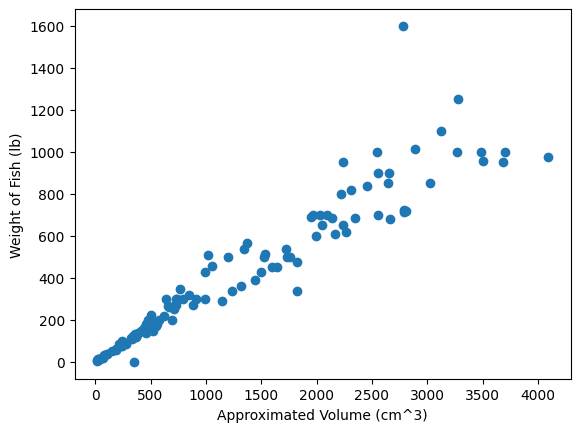

In [ ]:
# plot the volume vs. the weight

volumes = df["Vol"].values
weight = label["Weight"].values

plt.scatter(volumes, weight)
plt.ylabel("Weight of Fish (lb)")
plt.xlabel("Approximated Volume (cm^3)")
plt.show()

# the problem with this method is that the higher weights start to spread out

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [ ]:
def create_design(xcol, n):
  # assume xcol is shaped (n-samples, 1)
  # find xcol ** i for every i=1, 2..., n

  all_col = []
  for i in range(1, n + 1):
    all_col.append(xcol ** i)
  result = np.hstack(all_col)
  return result

In [ ]:
# function for determining best mse thresholds

def find_mse(data):
  # print(np.var(data))
  return np.var(data)*0.1

In [ ]:
# normalize the x (easier to look and compare mse)
volumes = volumes.reshape(-1, 1)

scaler_X = StandardScaler()

vol = scaler_X.fit_transform(volumes)

# sort the volumes (make a linearly increasing bottom for graphing)
sorted_idx = np.argsort(vol.flatten())

In [ ]:
# function for training

def train(model_obj):
  # helpers to check for the best model
  best_mse = [np.inf, np.inf]
  best_order = -np.inf
  best_model = model_obj
  best_alpha = 0

  tuple_of = ()

  alpha_params = {"alpha": [0.001, 0.01, 0.1, 1.0, 100]}

  # testing polynomial shapes
  for i in range(1, 11):
    X = create_design(vol, i)

    X_train, X_test, y_train, y_test = train_test_split(X, weight, random_state=42)

    if type(model_obj).__name__ == "Ridge" or type(model_obj).__name__ == "Lasso":
      grid = GridSearchCV(model_obj, alpha_params, scoring='neg_mean_squared_error', cv=5)
      grid.fit(X_train, y_train)

      best_ridge = grid.best_estimator_
      best_alpha = grid.best_params_['alpha']

    model = model_obj.__class__()

    model.fit(X_train, y_train)
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    y_preds_full = model.predict(X)

    # checking with a naive model (putting mean for all)
    naive_mse = mean_squared_error(np.full_like(y_preds_full, np.mean(y_preds_full)), y_preds_full)
    print(f"{i} - Naive MSE: {naive_mse}")

    print(f"{i} - Best MSE: {find_mse(y_preds_full)}")

    train_mse = mean_squared_error(y_train, y_train_preds)
    test_mse = mean_squared_error(y_test, y_test_preds)
    print(f"{i} - Training MSE: {train_mse}")
    print(f"{i} - Test MSE: {test_mse}")

    # check for best mse + order
    if test_mse < best_mse[1] and test_mse < find_mse(y_preds_full):
      best_order = i
      best_mse = [train_mse, test_mse]
      best_model = model
      tuple_of = (vol, weight, vol[sorted_idx], y_preds_full[sorted_idx], best_order, best_alpha, best_model)
  print(f"Best order polynomial: {best_order}")
  return tuple_of

In [ ]:
# polynomial approach
# best results; started overfitting around 8
# best order: 3

lvol_og, lweight_og, lvol_pred, lweight_full, lbest, lalpha, lmodel = train(LinearRegression(fit_intercept=True))

1 - Naive MSE: 104689.82888701072
1 - Best MSE: 10468.982888701074
1 - Training MSE: 10820.703154800814
1 - Test MSE: 11094.704372470176
2 - Naive MSE: 101497.63102909166
2 - Best MSE: 10149.763102909166
2 - Training MSE: 10479.949684623807
2 - Test MSE: 9027.794940507407
3 - Naive MSE: 100189.64514545767
3 - Best MSE: 10018.964514545769
3 - Training MSE: 10420.835318910458
3 - Test MSE: 8173.825065820847
4 - Naive MSE: 98716.25037342416
4 - Best MSE: 9871.625037342417
4 - Training MSE: 9845.27516508355
4 - Test MSE: 10239.866180058592
5 - Naive MSE: 98924.50184890299
5 - Best MSE: 9892.4501848903
5 - Training MSE: 9723.781080051764
5 - Test MSE: 21322.114140211113
6 - Naive MSE: 106332.66259165789
6 - Best MSE: 10633.26625916579
6 - Training MSE: 9423.069658145809
6 - Test MSE: 11911.70228165267
7 - Naive MSE: 109464.23897738074
7 - Best MSE: 10946.423897738074
7 - Training MSE: 9420.107690011358
7 - Test MSE: 17401.76623104997
8 - Naive MSE: 114659.0888684806
8 - Best MSE: 11465.9088

In [ ]:
# lasso approach
# overfit a lot, even the best plot with the test mse was overfit
# best order: 8

svol_og, sweight_og, svol_pred, sweight_full, sbest, salpha, smodel = train(Lasso(fit_intercept=True))

1 - Naive MSE: 103867.82526194864
1 - Best MSE: 10386.782526194866
1 - Training MSE: 10821.975914782373
1 - Test MSE: 11030.638687997116
2 - Naive MSE: 100982.01471960433
2 - Best MSE: 10098.201471960434
2 - Training MSE: 10485.256065716387
2 - Test MSE: 9134.284432900611
3 - Naive MSE: 99821.05552216961
3 - Best MSE: 9982.105552216963
3 - Training MSE: 10427.244422947946
3 - Test MSE: 8315.1399856822
4 - Naive MSE: 98025.08667378021
4 - Best MSE: 9802.508667378022
4 - Training MSE: 9864.268852696772
4 - Test MSE: 8931.825044100558
5 - Naive MSE: 97884.79923572122
5 - Best MSE: 9788.479923572122
5 - Training MSE: 9746.352906282555
5 - Test MSE: 16342.821703911915
6 - Naive MSE: 97869.41637207329
6 - Best MSE: 9786.94163720733
6 - Training MSE: 9743.660933335372
6 - Test MSE: 15984.163824662955


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e+05, tolerance: 5.806e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.198e+05, tolerance: 6.996e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e+05, tolerance: 7.610e

7 - Naive MSE: 98348.25833992213
7 - Best MSE: 9834.825833992214
7 - Training MSE: 9692.914772029442
7 - Test MSE: 10290.456264526325


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.064e+05, tolerance: 8.656e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.064e+05, tolerance: 8.656e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e+05, tolerance: 5.806e

8 - Naive MSE: 101440.54652978401
8 - Best MSE: 10144.054652978402
8 - Training MSE: 9647.02765289601
8 - Test MSE: 7625.691663264339
9 - Naive MSE: 104112.49958061388
9 - Best MSE: 10411.249958061388
9 - Training MSE: 9648.595604887692
9 - Test MSE: 10304.345203257217
10 - Naive MSE: 108220.95775675909
10 - Best MSE: 10822.095775675909
10 - Training MSE: 9654.641228698296
10 - Test MSE: 17158.824312642268
Best order polynomial: 8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.826e+05, tolerance: 7.610e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.550e+05, tolerance: 6.900e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.551e+05, tolerance: 7.278e

In [ ]:
# ridge approach
# overfit A LOT, even the best model was overfit, though not as bad as the lasso model
# best order: 9

rvol_og, rweight_og, rvol_pred, rweight_full, rbest, ralpha, rmodel = train(Ridge(fit_intercept=True))

1 - Naive MSE: 101882.11293879664
1 - Best MSE: 10188.211293879664
1 - Training MSE: 10835.695810158117
1 - Test MSE: 10897.455520413649
2 - Naive MSE: 99056.53970414678
2 - Best MSE: 9905.653970414678
2 - Training MSE: 10503.904442015497
2 - Test MSE: 9180.338499443931
3 - Naive MSE: 98547.88883638234
3 - Best MSE: 9854.788883638234
3 - Training MSE: 10470.849032306576
3 - Test MSE: 8817.013011073785
4 - Naive MSE: 97070.87688738751
4 - Best MSE: 9707.087688738751
4 - Training MSE: 9888.288929533252
4 - Test MSE: 10755.795797776838
5 - Naive MSE: 97451.37334175264
5 - Best MSE: 9745.137334175264
5 - Training MSE: 9770.683273923984
5 - Test MSE: 21717.3011705938
6 - Naive MSE: 98348.4732301547
6 - Best MSE: 9834.84732301547
6 - Training MSE: 9572.705323063452
6 - Test MSE: 8407.826610527945
7 - Naive MSE: 101220.12287628993
7 - Best MSE: 10122.012287628993
7 - Training MSE: 9568.092007700427
7 - Test MSE: 7954.841898275913
8 - Naive MSE: 124805.33509092464
8 - Best MSE: 12480.533509092

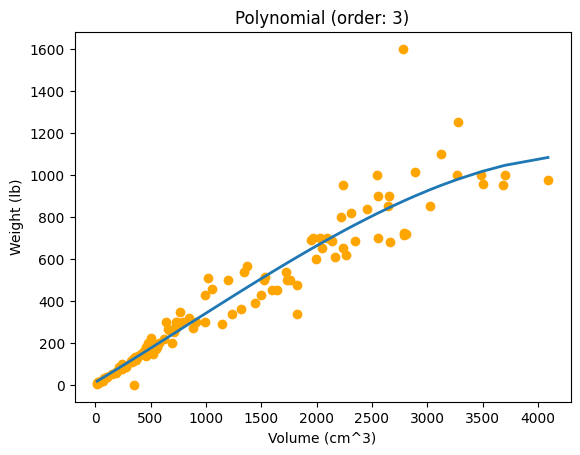

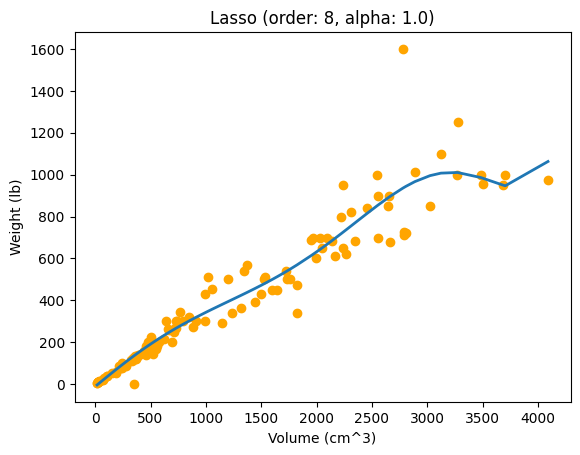

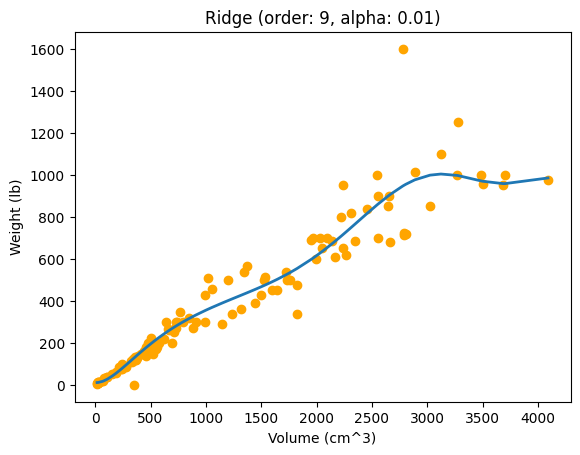

In [ ]:
# plotting data

lvol_pred = scaler_X.inverse_transform(lvol_pred)
lvol_og = scaler_X.inverse_transform(lvol_og)
plt.plot(lvol_pred, lweight_full, linewidth=2)
plt.scatter(lvol_og, lweight_og, color="orange")
plt.title(f"Polynomial (order: {lbest})")
plt.xlabel("Volume (cm^3)")
plt.ylabel("Weight (lb)")
plt.show()

svol_pred = scaler_X.inverse_transform(svol_pred)
svol_og = scaler_X.inverse_transform(svol_og)
plt.plot(svol_pred, sweight_full, linewidth=2)
plt.scatter(svol_og, sweight_og, color="orange")
plt.title(f"Lasso (order: {sbest}, alpha: {salpha})")
plt.xlabel("Volume (cm^3)")
plt.ylabel("Weight (lb)")
plt.show()

rvol_pred = scaler_X.inverse_transform(rvol_pred)
rvol_og = scaler_X.inverse_transform(rvol_og)
plt.plot(rvol_pred, rweight_full, linewidth=2)
plt.scatter(rvol_og, rweight_og, color="orange")
plt.title(f"Ridge (order: {rbest}, alpha: {ralpha})")
plt.xlabel("Volume (cm^3)")
plt.ylabel("Weight (lb)")
plt.show()

In [ ]:
try:
  fish_length1 = float(input("Input the first length of the fish in cm: "))
  fish_length2 = float(input("Input the second length of the fish in cm: "))
  fish_length3 = float(input("Input the third length of the fish in cm: "))
  fish_height = float(input("Input the height of the fish in cm: "))
  fish_width = float(input("Input the width of the fish in cm: "))
except Exception as e:
  print(e, "- Measurements must be numbers!!")

fish_vol = np.mean((fish_length1, fish_length2, fish_length3)) * np.pi * fish_height * fish_width

fish_vol_scaled = scaler_X.transform([[fish_vol]])
fish_vol_scaled = np.array(fish_vol_scaled)

X_l = create_design(fish_vol_scaled, lbest)
X_s = create_design(fish_vol_scaled, sbest)
X_r = create_design(fish_vol_scaled, rbest)

weight_pred = lmodel.predict(X_l)
print(f"Polynomial: {round(weight_pred[0], 2)}lbs")
weight_pred = smodel.predict(X_s)
print(f"Lasso: {round(weight_pred[0], 2)}lbs")
weight_pred = rmodel.predict(X_r)
print(f"Ridge: {round(weight_pred[0], 2)}lbs")

Input the first length of the fish in cm: 1
Input the second length of the fish in cm: 2
Input the third length of the fish in cm: 3
Input the height of the fish in cm: 4
Input the width of the fish in cm: 5
Polynomial: 52.29lb
Lasso: 43.48lb
Ridge: 32.56lb
